In [1]:
import pickle as pkl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import hmean
import json
import torch
import pandas as pd

import seaborn as sns

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib as mpl

/local/zemel/max/conda/memoryllm/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
models = {
    # "naive_model": "Base",
    "llama3_ft": "ICL-FT",
    "rag_trained": "RAG-FT",
    "memoryllm": "MemLLM",
    "gnm": "GNM",
}

model_keys = list(models.keys())
model_names = list(models.values())

In [3]:
model_keys, model_names

(['llama3_ft', 'rag_trained', 'memoryllm', 'gnm'],
 ['ICL-FT', 'RAG-FT', 'MemLLM', 'GNM'])

In [4]:
data = dict()

for model_key, model_name in models.items():

    data_root = f"../saved_evals/warmup_seq_10/{model_key}/summary.json"

    # Open the file and load the data
    with open(data_root, 'r') as json_file:
        data_dict = json.load(json_file)

    data[model_key] = data_dict
    data[model_key]["model_name"] = model_name

In [5]:
def upper_triangle(mat, k=0):
    """
    Keep diagonal+above (k=0). If you want strictly above diagonal, use k=1.
    """
    mat = np.array(mat, dtype=float, copy=True)
    mat[np.tril_indices_from(mat, k=k-1)] = np.nan  # below-diagonal -> NaN
    return mat

In [6]:
def annotate_heatmap(ax, mat, fmt="{:.2f}", fontsize=7, threshold=0.5):
    """
    Writes values into each non-NaN cell of `mat`.
    `threshold` controls when to switch text color for readability.
    """
    for (i, j), v in np.ndenumerate(mat):
        if np.isnan(v):
            continue
        color = "white" if v < threshold else "black"
        ax.text(j, i, fmt.format(v), ha="center", va="center",
                fontsize=fontsize, color=color, fontfamily="monospace")


In [7]:

colors = [ '#C44E52',  '#CCB974', '#55A868']


cmap = mpl.colors.LinearSegmentedColormap.from_list("custom6", colors, N=256).copy()
cmap.set_bad(alpha=0.0)  # keep your NaN-masked triangle transparent

llama3_ft ICL-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.984259,"[[0.9930555820465088, 0.9976851940155029, 0.99...","[0.9930555820465088, 0.9745370149612427, 0.983...","[0.9842592477798462, 0.9881687164306641, 0.984...",0.572685,"[[0.6805555820465088, 0.6620370149612427, 0.63...",0.784722,"[[0.8148148059844971, 0.7777777910232544, 0.75...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.950521,0.0,ICL-FT


--------------------


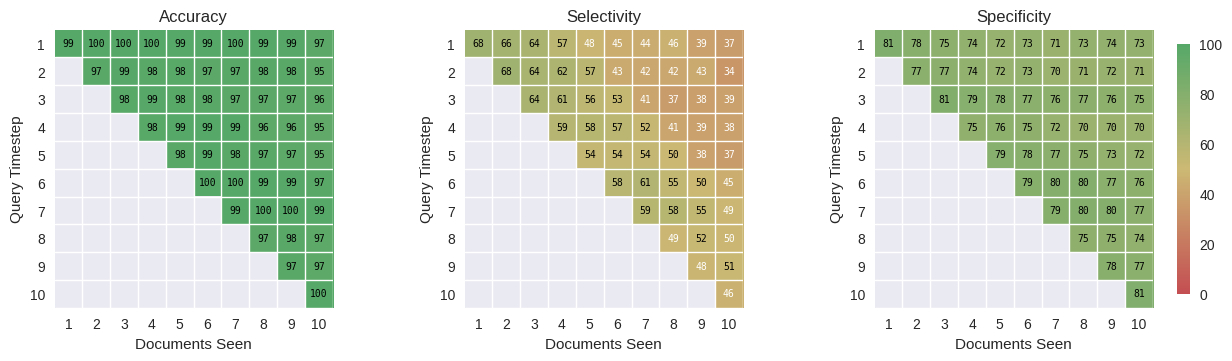

rag_trained RAG-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.887269,"[[0.9745370149612427, 0.9513888955116272, 0.92...","[0.9745370149612427, 0.9513888955116272, 0.930...","[0.8872685432434082, 0.8801440596580505, 0.876...",0.581481,"[[0.5555555820465088, 0.5879629850387573, 0.56...",0.736111,"[[0.7685185074806213, 0.7268518805503845, 0.72...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.188347,0.0,RAG-FT


--------------------


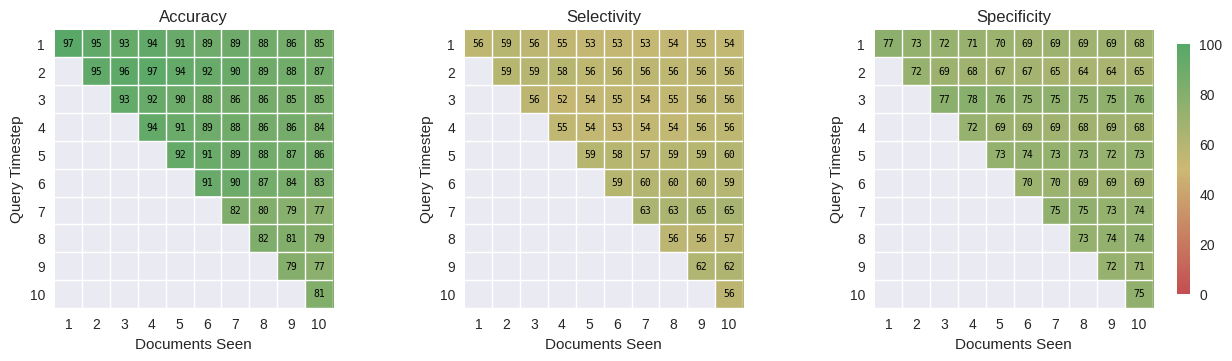

memoryllm MemLLM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.800231,"[[0.8379629850387573, 0.7777777910232544, 0.72...","[0.8379629850387573, 0.7708333134651184, 0.824...","[0.8002314567565918, 0.744084358215332, 0.6727...",0.178241,"[[0.1527777761220932, 0.2083333283662796, 0.25...",0.789352,"[[0.7546296119689941, 0.7916666865348816, 0.82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.66097,0.0,MemLLM


--------------------


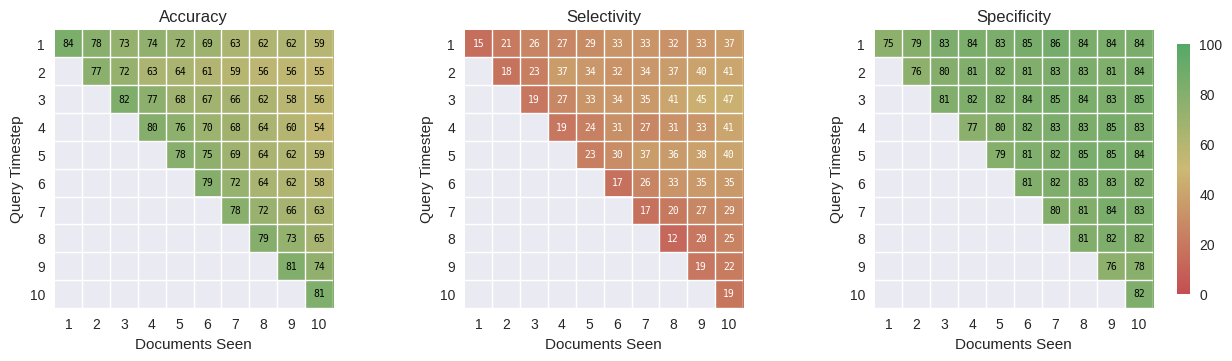

gnm GNM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.977546,"[[0.9814814925193787, 0.9722222089767456, 0.97...","[0.9814814925193787, 0.9884259104728699, 0.995...","[0.9775462746620178, 0.974022626876831, 0.9713...",0.898148,"[[0.8518518805503845, 0.8611111044883728, 0.84...",0.84213,"[[0.8333333134651184, 0.8333333134651184, 0.81...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.567716,0.0,GNM


--------------------


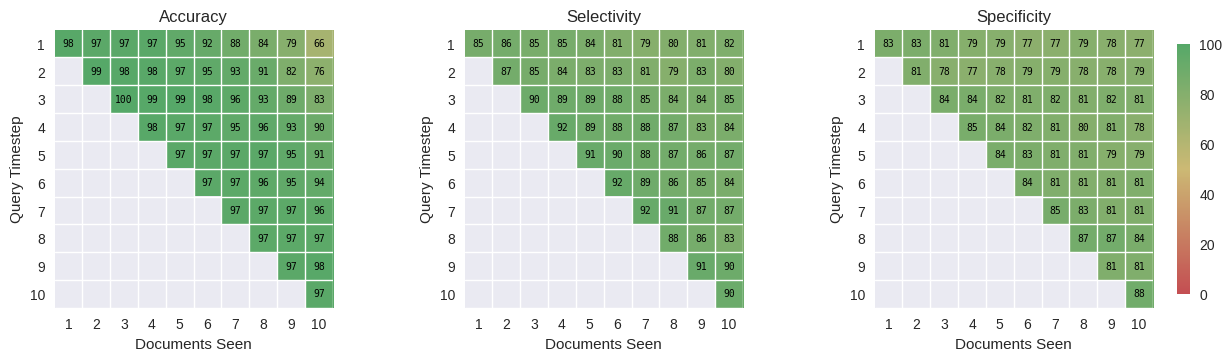

In [8]:
# n_steps = 10


for model_key, model_name in models.items():

    print(model_key, model_name)

    model_data = data[model_key]
    view_df = pd.DataFrame(model_data)
    display(view_df)

    print("-"*20)

    item = view_df.iloc[0]

    # f_acc_mat = np.array(item["fact_accuracy_matrix"])[:n_steps, :n_steps]

    # f_sel_mat = np.array(item["fact_selectivity_matrix"])[:n_steps, :n_steps]

    # f_spec_mat = np.array(item["fact_specificity_matrix"])[:n_steps, :n_steps]

    f_acc_mat  = np.array(item["fact_accuracy_matrix"]) * 100
    f_sel_mat  = np.array(item["fact_selectivity_matrix"]) * 100
    f_spec_mat = np.array(item["fact_specificity_matrix"]) * 100


    mats = {
        "Accuracy":     upper_triangle(f_acc_mat, k=0),
        "Selectivity":  upper_triangle(f_sel_mat, k=0),
        "Specificity":  upper_triangle(f_spec_mat, k=0),
    }

    # vmin, vmax = 0.0, 1.0
    vmin, vmax = 0, 100


    fig, axes = plt.subplots(1, 3, 
                            figsize=(13, 3.5), 
                            # sharey=True, 
                            constrained_layout=True
                        )

    ims = []
    for ax, (title, mat) in zip(axes, mats.items()):
        mat = np.asarray(mat)


        im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap, interpolation="nearest")

        # im = ax.imshow(mat, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="nearest")
        annotate_heatmap(ax, mat, fmt="{:.0f}", fontsize=7, threshold=(vmin+vmax)/2)
        ims.append(im)
        
        m, n = mat.shape

        # major ticks (labels) at centers
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(m))

        ax.set_xticklabels(np.arange(n)+1)
        ax.set_yticklabels(np.arange(m)+1)

        # minor ticks (grid) at boundaries between cells
        ax.set_xticks(np.arange(0.5, n, 1), minor=True)
        ax.set_yticks(np.arange(0.5, m, 1), minor=True)

        ax.grid(False)
        ax.grid(which="minor", linestyle="-")
        ax.tick_params(which="minor", bottom=False, left=False)  # hide minor tick marks
        
        ax.set_title(title)
        ax.set_xlabel("Documents Seen")
        ax.set_ylabel("Query Timestep")

    # One shared colorbar for all three
    # fig.suptitle(model_name)
    fig.colorbar(ims[0], ax=axes, shrink=0.9, pad=0.02)
    # fig.tight_layout()

    plt.savefig(f"../plots/warmup_{model_key}_heatmaps.png", dpi=600)
    plt.show()

    # break

llama3_ft ICL-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.984259,"[[0.9930555820465088, 0.9976851940155029, 0.99...","[0.9930555820465088, 0.9745370149612427, 0.983...","[0.9842592477798462, 0.9881687164306641, 0.984...",0.572685,"[[0.6805555820465088, 0.6620370149612427, 0.63...",0.784722,"[[0.8148148059844971, 0.7777777910232544, 0.75...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.950521,0.0,ICL-FT


--------------------
rag_trained RAG-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.887269,"[[0.9745370149612427, 0.9513888955116272, 0.92...","[0.9745370149612427, 0.9513888955116272, 0.930...","[0.8872685432434082, 0.8801440596580505, 0.876...",0.581481,"[[0.5555555820465088, 0.5879629850387573, 0.56...",0.736111,"[[0.7685185074806213, 0.7268518805503845, 0.72...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.188347,0.0,RAG-FT


--------------------
memoryllm MemLLM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.800231,"[[0.8379629850387573, 0.7777777910232544, 0.72...","[0.8379629850387573, 0.7708333134651184, 0.824...","[0.8002314567565918, 0.744084358215332, 0.6727...",0.178241,"[[0.1527777761220932, 0.2083333283662796, 0.25...",0.789352,"[[0.7546296119689941, 0.7916666865348816, 0.82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.66097,0.0,MemLLM


--------------------


gnm GNM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.977546,"[[0.9814814925193787, 0.9722222089767456, 0.97...","[0.9814814925193787, 0.9884259104728699, 0.995...","[0.9775462746620178, 0.974022626876831, 0.9713...",0.898148,"[[0.8518518805503845, 0.8611111044883728, 0.84...",0.84213,"[[0.8333333134651184, 0.8333333134651184, 0.81...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.567716,0.0,GNM


--------------------


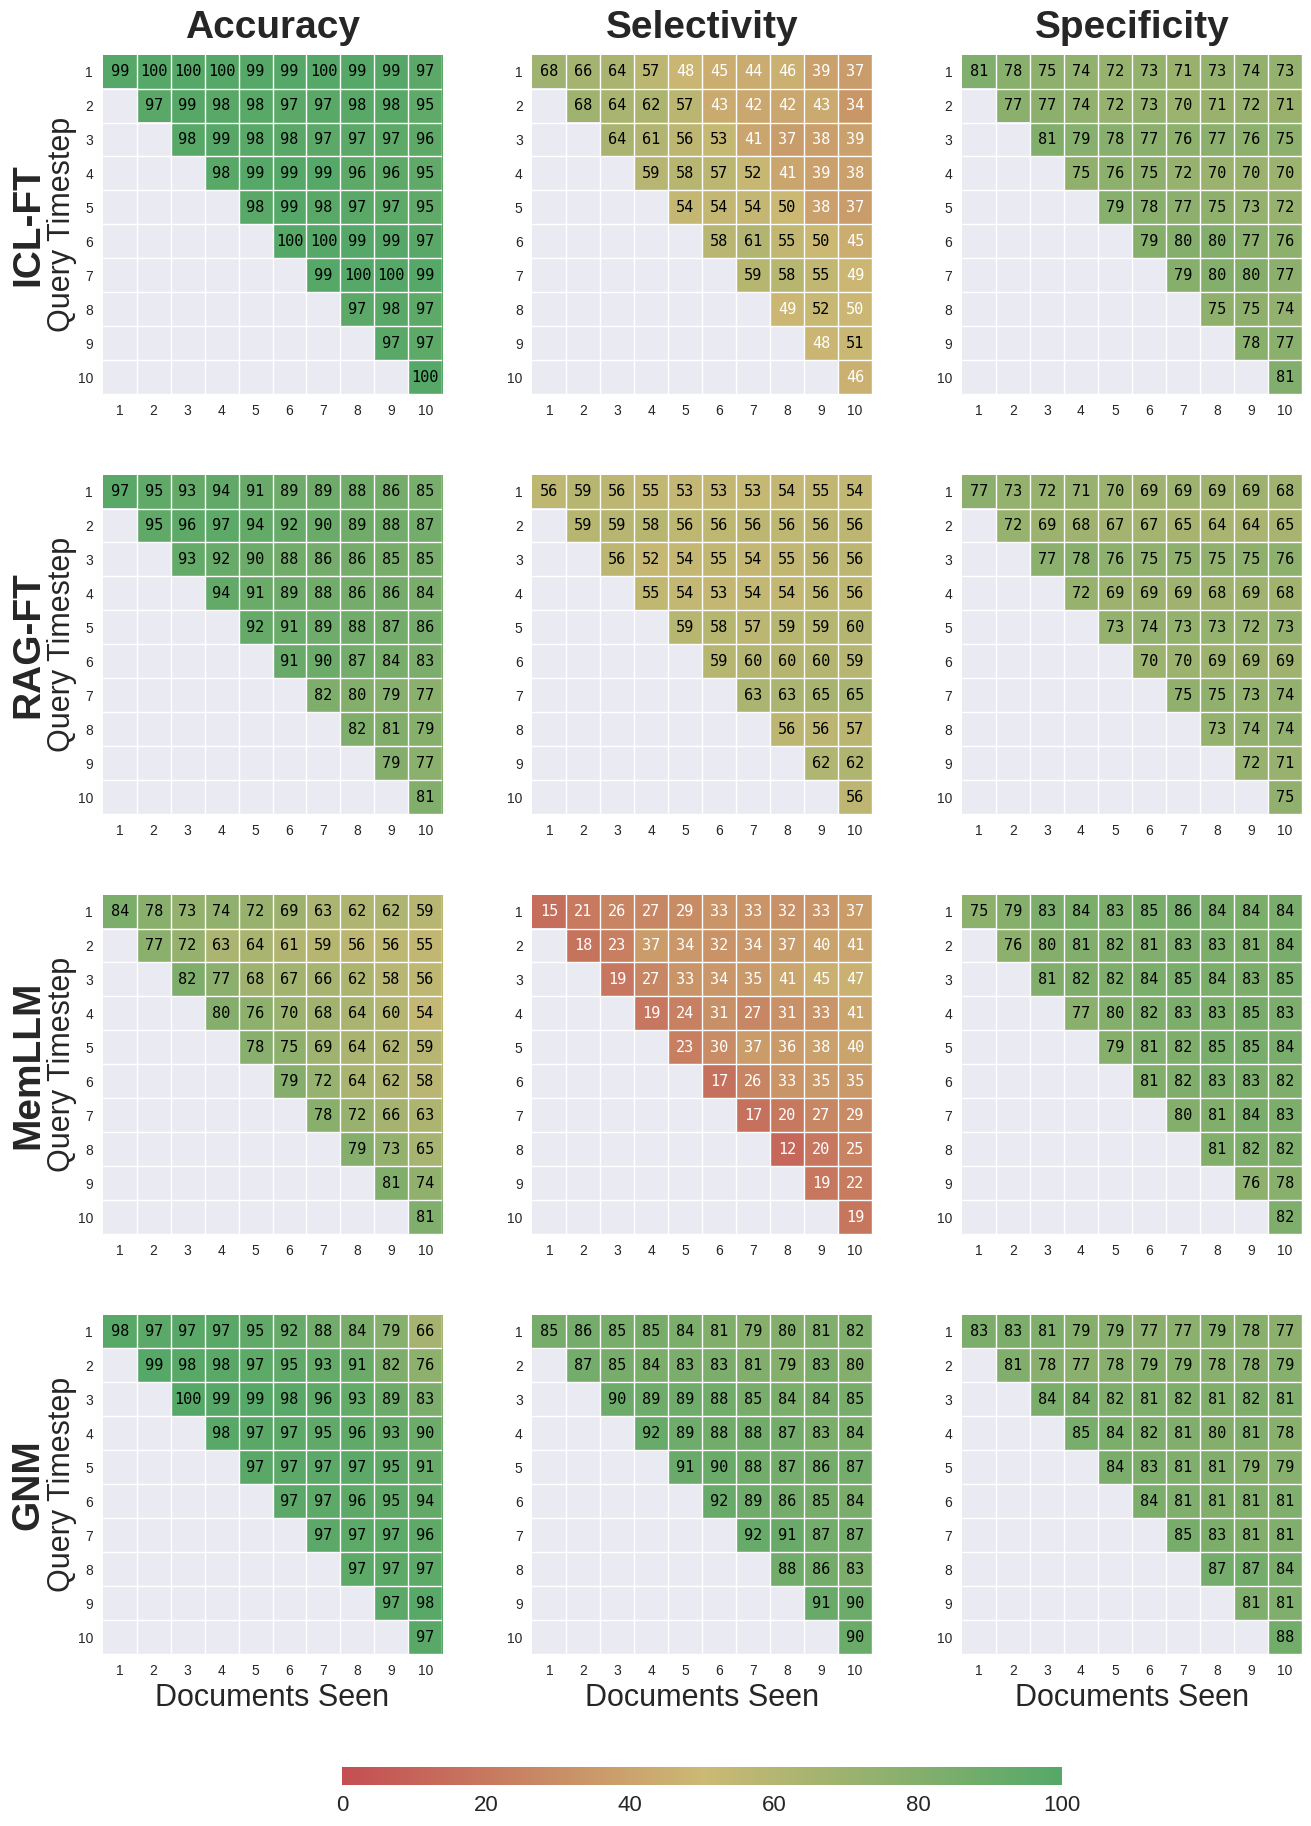

In [9]:
# n_steps = 10
n_models = len(models)
metric_names = ["Accuracy", "Selectivity", "Specificity"]

fig, axes = plt.subplots(n_models, 3, 
                        figsize=(13, 4.5*n_models), 
                        constrained_layout=True,
                        gridspec_kw={'wspace': 0.15, 'hspace': 0.12}
                    )

row_idx = 0
for model_key, model_name in models.items():

    print(model_key, model_name)

    model_data = data[model_key]
    view_df = pd.DataFrame(model_data)
    display(view_df)

    print("-"*20)

    item = view_df.iloc[0]

    f_acc_mat = np.array(item["fact_accuracy_matrix"]) * 100
    f_sel_mat = np.array(item["fact_selectivity_matrix"]) * 100
    f_spec_mat = np.array(item["fact_specificity_matrix"]) * 100

    mats = {
        "Accuracy":     upper_triangle(f_acc_mat, k=0),
        "Selectivity":  upper_triangle(f_sel_mat, k=0),
        "Specificity":  upper_triangle(f_spec_mat, k=0),
    }

    vmin, vmax = 0, 100

    col_idx = 0
    ims = []
    for ax, (title, mat) in zip(axes[row_idx, :], mats.items()):
        mat = np.asarray(mat)

        im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
        annotate_heatmap(ax, mat, fmt="{:.0f}", fontsize=11, threshold=(vmin+vmax)/2)
        ims.append(im)
        
        m, n = mat.shape

        # major ticks (labels) at centers
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(m))

        ax.set_xticklabels(np.arange(n)+1)
        ax.set_yticklabels(np.arange(m)+1)

        # minor ticks (grid) at boundaries between cells
        ax.set_xticks(np.arange(0.5, n, 1), minor=True)
        ax.set_yticks(np.arange(0.5, m, 1), minor=True)

        ax.grid(False)
        ax.grid(which="minor", linestyle="-", linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)  # hide minor tick marks
        
        # Global column titles only on first row
        if row_idx == 0:
            ax.set_title(title, fontsize=28, fontweight='bold', pad=12)
        else:
            ax.set_title("")
        
        # X-axis label only on bottom row
        if row_idx == n_models - 1:
            ax.set_xlabel("Documents Seen", fontsize=22)
        else:
            ax.set_xlabel("")
        
        # Y-axis: model name + "Query Timestep" only on leftmost column
        if col_idx == 0:
            ax.set_ylabel("")  # clear default ylabel

            # big + bold model name
            ax.text(
                -0.22, 0.5, model_name,
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="center",
                fontsize=28, fontweight="bold",
                clip_on=False,
            )

            # normal subtitle
            ax.text(
                -0.12, 0.5, "Query Timestep",
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="center",
                fontsize=22, fontweight="normal",
                clip_on=False,
            )
        else:
            ax.set_ylabel("")  # no y-label on middle/right columns

        col_idx += 1

    row_idx += 1

cbar = fig.colorbar(ims[0], ax=axes, shrink=0.6, pad=0.03, orientation="horizontal", aspect=40)
cbar.ax.tick_params(labelsize=16)
plt.savefig("../plots/warmup_all_heatmaps.png", dpi=600)
plt.show()

llama3_ft ICL-FT


,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,model_name
0,0.984954,"[[0.9953703880310059, 1.0, 0.9907407164573669,...","[0.9953703880310059, 0.9722222089767456, 0.976...","[0.9849537014961243, 0.9863547682762146, 0.982...",0.506944,"[[0.6851851940155029, 0.6481481194496155, 0.64...",0.772685,"[[0.8240740895271301, 0.7870370149612427, 0.76...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.978662,ICL-FT


--------------------
rag_trained RAG-FT


,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,model_name
0,0.814583,"[[0.9814814925193787, 0.9537037014961243, 0.95...","[0.9814814925193787, 0.9074074029922485, 0.916...","[0.8145833611488342, 0.8155457973480225, 0.814...",0.597685,"[[0.5740740895271301, 0.5925925970077515, 0.56...",0.711111,"[[0.7685185074806213, 0.7037037014961243, 0.68...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.383217,RAG-FT


--------------------
memoryllm MemLLM


,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,model_name
0,0.787731,"[[0.8287037014961243, 0.7731481194496155, 0.71...","[0.8287037014961243, 0.7638888955116272, 0.75,...","[0.7877314686775208, 0.7426900863647461, 0.680...",0.174537,"[[0.15740740299224854, 0.21296297013759613, 0....",0.793981,"[[0.7592592835426331, 0.7685185074806213, 0.82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.696887,MemLLM


--------------------
gnm GNM


,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,model_name
0,0.971759,"[[0.9629629850387573, 0.9768518805503845, 0.97...","[0.9629629850387573, 0.9907407164573669, 0.967...","[0.9717592597007751, 0.9707602262496948, 0.974...",0.905556,"[[0.8888888955116272, 0.8611111044883728, 0.85...",0.828704,"[[0.8240740895271301, 0.8333333134651184, 0.76...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.772253,GNM


--------------------


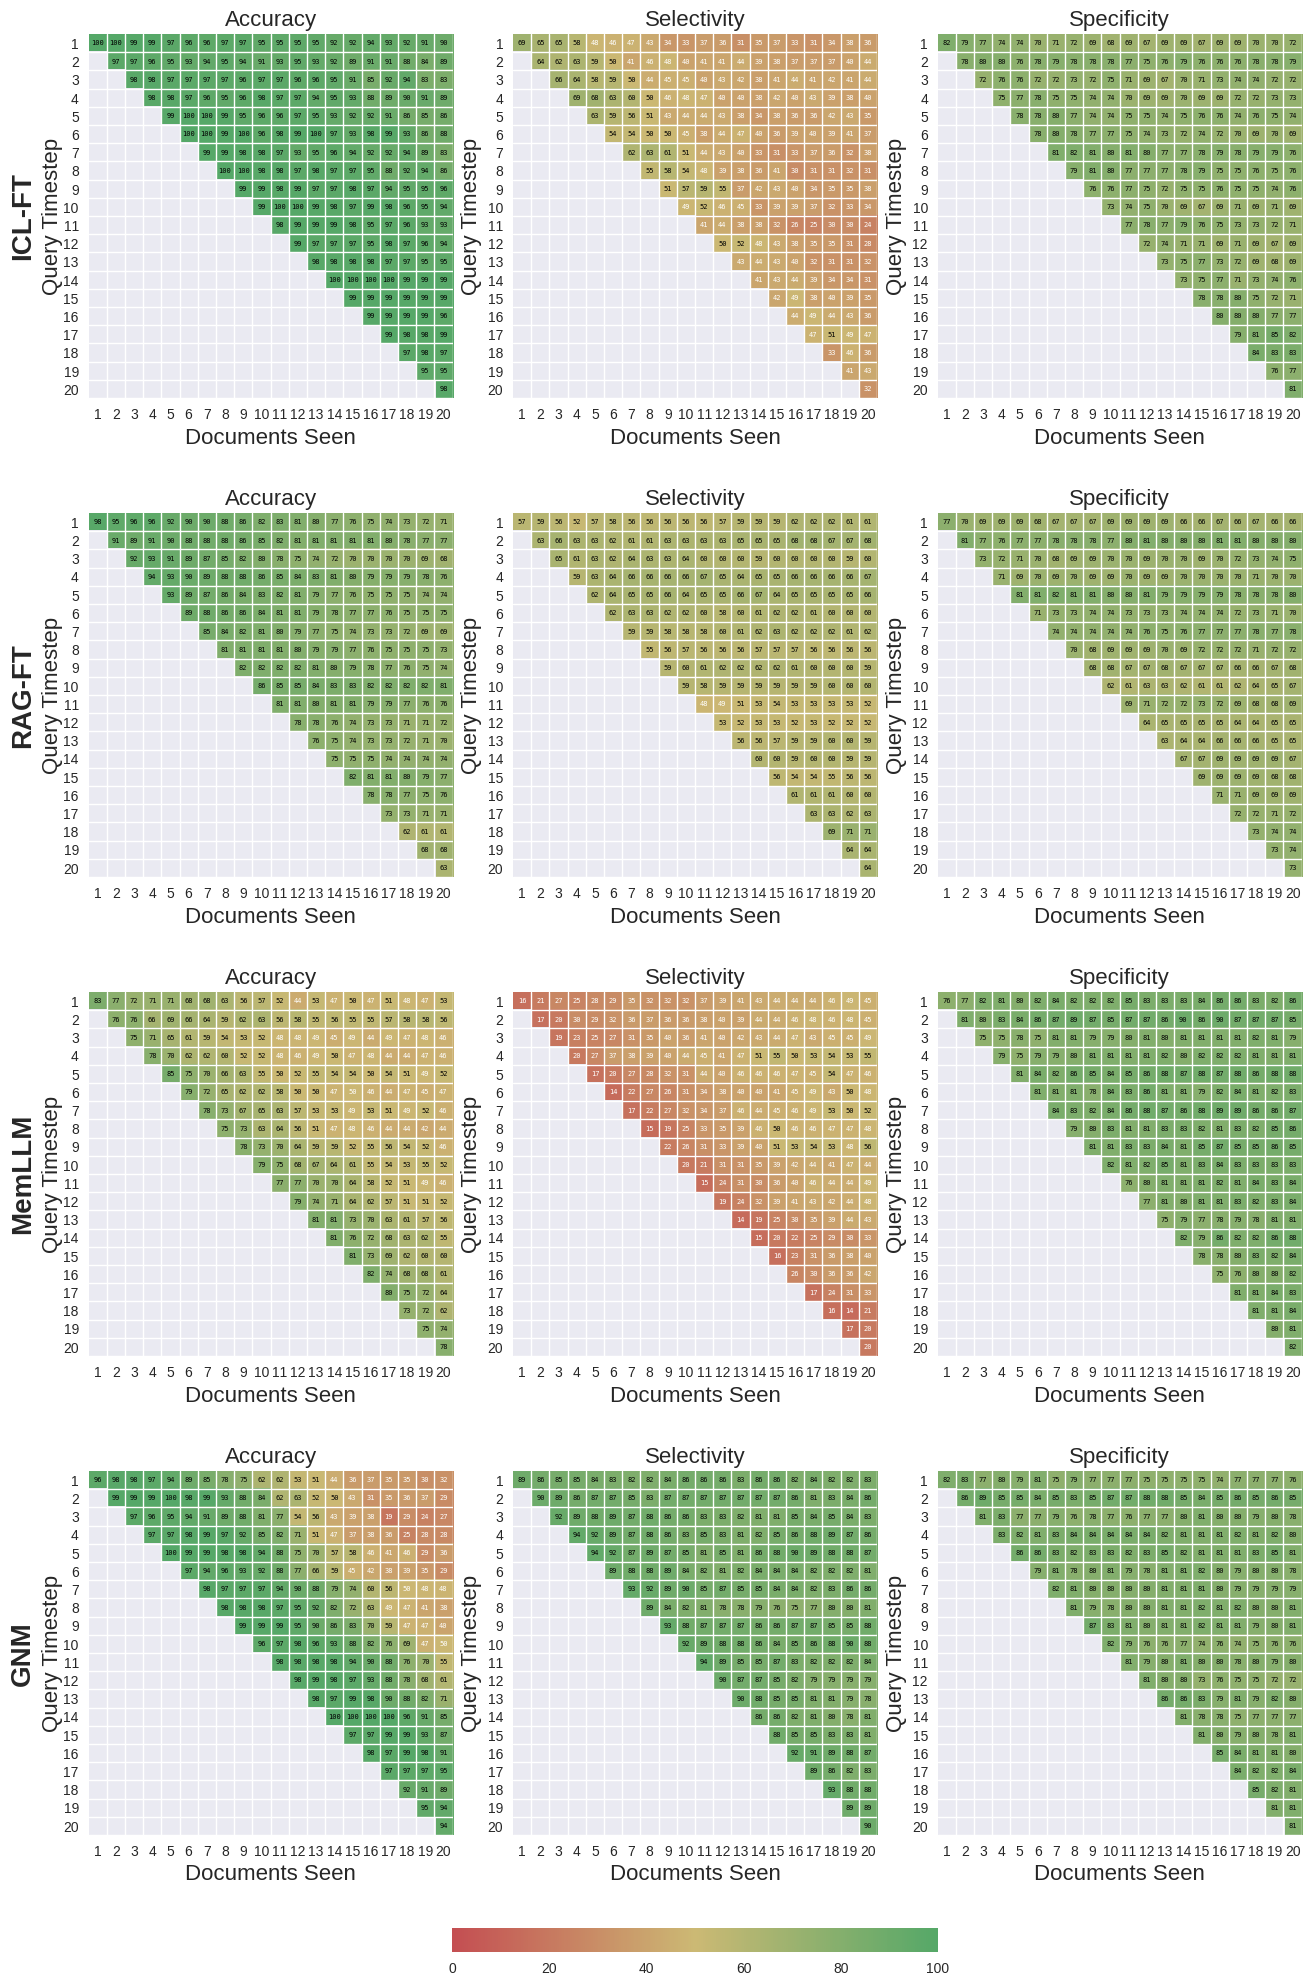

In [10]:
# Load data from warmup (20 elements) instead of warmup_seq_10
data_warmup = dict()

for model_key, model_name in models.items():
    data_root = f"../saved_evals/warmup/{model_key}/summary.json"
    with open(data_root, 'r') as json_file:
        data_dict = json.load(json_file)
    data_warmup[model_key] = data_dict
    data_warmup[model_key]["model_name"] = model_name

# Plot heatmaps for warmup (20 elements)
fig, axes = plt.subplots(len(models), 3, 
                        figsize=(13, 5*len(models)), 
                        constrained_layout=True
                    )

row_idx = 0
for model_key, model_name in models.items():

    print(model_key, model_name)

    model_data = data_warmup[model_key]
    view_df = pd.DataFrame(model_data)
    display(view_df)

    print("-"*20)

    item = view_df.iloc[0]

    f_acc_mat = np.array(item["fact_accuracy_matrix"]) * 100
    f_sel_mat = np.array(item["fact_selectivity_matrix"]) * 100
    f_spec_mat = np.array(item["fact_specificity_matrix"]) * 100

    mats = {
        "Accuracy":     upper_triangle(f_acc_mat, k=0),
        "Selectivity":  upper_triangle(f_sel_mat, k=0),
        "Specificity":  upper_triangle(f_spec_mat, k=0),
    }

    vmin, vmax = 0, 100

    col_idx = 0
    ims = []
    for ax, (title, mat) in zip(axes[row_idx, :], mats.items()):
        mat = np.asarray(mat)

        im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
        annotate_heatmap(ax, mat, fmt="{:.0f}", fontsize=5, threshold=(vmin+vmax)/2)
        ims.append(im)
        
        m, n = mat.shape

        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(m))

        ax.set_xticklabels(np.arange(n)+1)
        ax.set_yticklabels(np.arange(m)+1)

        ax.set_xticks(np.arange(0.5, n, 1), minor=True)
        ax.set_yticks(np.arange(0.5, m, 1), minor=True)

        ax.grid(False)
        ax.grid(which="minor", linestyle="-", linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Documents Seen", fontsize=16)
        if col_idx == 0:
            ax.set_ylabel("")
            ax.text(
                -0.18, 0.5, model_name,
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="center",
                fontsize=20, fontweight="bold",
                clip_on=False,
            )
            ax.text(
                -0.10, 0.5, "Query Timestep",
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="center",
                fontsize=16, fontweight="normal",
                clip_on=False,
            )
        else:
            ax.set_ylabel(f"Query Timestep", fontsize=16)

        col_idx += 1

    row_idx += 1

fig.colorbar(ims[0], ax=axes, shrink=0.4, pad=0.02, orientation="horizontal")
plt.savefig("../plots/warmup_20_all_heatmaps.png", dpi=600)
plt.show()

llama3_ft ICL-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.984259,"[[0.9930555820465088, 0.9976851940155029, 0.99...","[0.9930555820465088, 0.9745370149612427, 0.983...","[0.9842592477798462, 0.9881687164306641, 0.984...",0.572685,"[[0.6805555820465088, 0.6620370149612427, 0.63...",0.784722,"[[0.8148148059844971, 0.7777777910232544, 0.75...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.950521,0.0,ICL-FT


--------------------
gnm GNM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,model_name
0,0.0,0.977546,"[[0.9814814925193787, 0.9722222089767456, 0.97...","[0.9814814925193787, 0.9884259104728699, 0.995...","[0.9775462746620178, 0.974022626876831, 0.9713...",0.898148,"[[0.8518518805503845, 0.8611111044883728, 0.84...",0.84213,"[[0.8333333134651184, 0.8333333134651184, 0.81...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.567716,0.0,GNM


--------------------


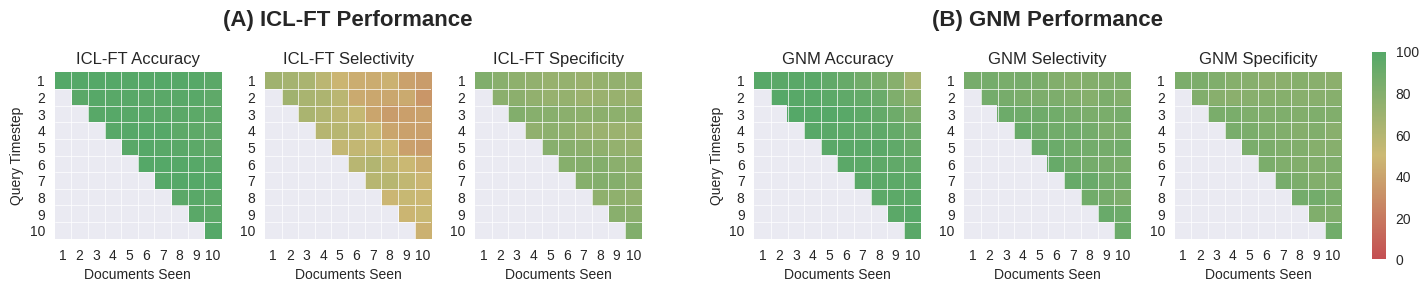

In [11]:
# now make a version that has just GNM and ICL-FT side by side, showing all three metrics
# Use gridspec to add a gap between the two model groups
fig = plt.figure(figsize=(20, 4.5))
gs = fig.add_gridspec(1, 7, width_ratios=[1, 1, 1, 0.15, 1, 1, 1], wspace=0.3)

model_subset = ["llama3_ft", "gnm"]
metric_names = ["Accuracy", "Selectivity", "Specificity"]
group_titles = ["(A) ICL-FT Performance", "(B) GNM Performance"]

# Map ax_idx to gridspec positions (skip index 3 which is the gap)
gs_positions = [0, 1, 2, 4, 5, 6]

ax_idx = 0
axes = []
group_idx = 0
for model_key in model_subset:

    model_name = models[model_key]

    print(model_key, model_name)

    model_data = data[model_key]
    view_df = pd.DataFrame(model_data)
    display(view_df)

    print("-"*20)

    item = view_df.iloc[0]

    f_acc_mat = np.array(item["fact_accuracy_matrix"]) * 100
    f_sel_mat = np.array(item["fact_selectivity_matrix"]) * 100
    f_spec_mat = np.array(item["fact_specificity_matrix"]) * 100

    mats = {
        "Accuracy":     upper_triangle(f_acc_mat, k=0),
        "Selectivity":  upper_triangle(f_sel_mat, k=0),
        "Specificity":  upper_triangle(f_spec_mat, k=0),
    }

    vmin, vmax = 0, 100

    metric_idx = 0
    for metric_name in metric_names:
        ax = fig.add_subplot(gs[0, gs_positions[ax_idx]])
        axes.append(ax)
        mat = mats[metric_name]

        im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
        
        m, n = mat.shape

        # major ticks (labels) at centers
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(m))

        ax.set_xticklabels(np.arange(n)+1)
        ax.set_yticklabels(np.arange(m)+1)

        # minor ticks (grid) at boundaries between cells
        ax.set_xticks(np.arange(0.5, n, 1), minor=True)
        ax.set_yticks(np.arange(0.5, m, 1), minor=True)

        ax.grid(False)
        ax.grid(which="minor", linestyle="-", linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)  # hide minor tick marks
        
        # Only show metric name in subplot title
        ax.set_title(f"{model_name} {metric_name}", fontsize=12)
        ax.set_xlabel("Documents Seen", fontsize=10)
        if ax_idx == 0 or ax_idx == 3:
            ax.set_ylabel("Query Timestep", fontsize=10)
        
        # Add group title above the middle subplot (metric_idx == 1)
        if metric_idx == 1:
            ax.annotate(group_titles[group_idx], xy=(0.5, 1.0), xytext=(0.5, 1.25),
                       xycoords='axes fraction', textcoords='axes fraction',
                       fontsize=16, fontweight='bold', ha='center', va='bottom')
        
        ax_idx += 1
        metric_idx += 1
    
    group_idx += 1

# Colorbar on the right - use aspect to control height relative to width
cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.02, orientation="vertical", aspect=15)
plt.savefig("../plots/warmup_iclft_gnm_heatmaps.png", dpi=600, bbox_inches='tight')
plt.show()